In [1]:
import sys
import numpy as np
import pandas as pd
import librosa
import librosa.display
import IPython.display

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter

# load other modules --> repo root path
sys.path.insert(0, "../")

from utils import text
from utils import audio
from training.params import Params as hp
from dataset.dataset import TextToSpeechDataset

### Load parameters 

In [2]:
hp.load("../params/analyze.json")

In [3]:
hp.dataset

'ljspeech'

### Load dataset and prepare data

In [2]:
dataset_root = "../data/" + hp.dataset
data = TextToSpeechDataset(hp.dataset, dataset_root)

In [59]:
durations = []
lengths = []
num_words = []
for i in range(len(data)): 
    char_seq, waveform = data.load_item(i, load_waveform=True)  
    utterance = text.to_text(char_seq)
    clear_utterance = text.remove_punctuation(utterance)
    clear_words = clear_utterance.split()  
    durations.append(audio.duration(waveform))
    lengths.append(len(utterance))
    num_words.append(len(clear_words))

In [22]:
hp.use_phonemes = True
hp.use_punctuation = False
phonemes = dataset_root + "/phonemes/wo_punctuation.txt"
data_phon = TextToSpeechDataset(hp.dataset, dataset_root, cache_file_phonemes=phonemes)

In [23]:
lengths_phon = []
freq_phon = Counter()
for i in range(len(data_phon)): 
    char_seq, waveform = data_phon.load_item(i, load_waveform=True)  
    utterance = text.to_text(char_seq)
    lengths_phon.append(len(utterance))
    utterance = utterance.replace(' ', '')
    freq_phon.update(utterance)

## Audio & Spectrogram test

In [3]:
char_seq, waveform = data.load_item(1, load_waveform=True)  
print(text.to_text(char_seq))
print(audio.duration(waveform))
melspec = audio.mel_spectrogram(waveform)
spec = audio.spectrogram(waveform)

in being comparatively modern.
1.899546485260771


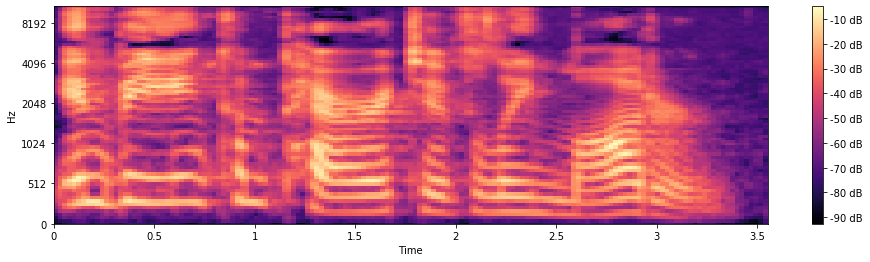

In [4]:
plt.figure(figsize=(16, 4))
mel_spec_shift = melspec + hp.reference_spectrogram_db
baf = librosa.display.specshow(mel_spec_shift, sr=hp.sample_rate, x_axis='time', y_axis='mel', cmap='magma');
plt.colorbar(format='%+2.0f dB');

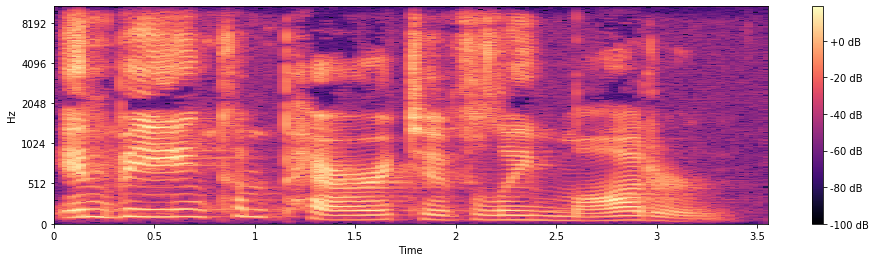

In [5]:
plt.figure(figsize=(16, 4))
spec_shift = spec + hp.reference_spectrogram_db
librosa.display.specshow(spec_shift, x_axis='time', y_axis='mel', cmap='magma');
plt.colorbar(format='%+2.0f dB');

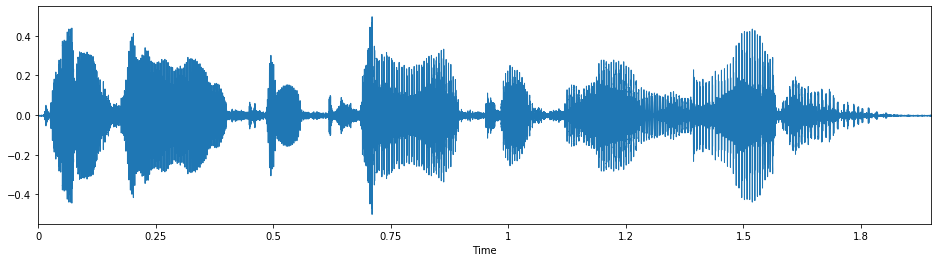

In [12]:
plt.figure(figsize=(16, 4))
librosa.display.waveplot(waveform, sr=hp.sample_rate);

In [7]:
IPython.display.Audio(data=waveform, rate=hp.sample_rate)

## Inverse spectrogram test

In [7]:
inverse_spec = audio.inverse_spectrogram(spec)
IPython.display.Audio(data=inverse_spec, rate=hp.sample_rate)

In [9]:
inverse_melspec = audio.inverse_mel_spectrogram(melspec)
IPython.display.Audio(data=inverse_melspec, rate=hp.sample_rate)

# Analysis

In [60]:
#set full-width figure
sns.set(rc={'figure.figsize':(16,4)})
# set seaborn skin
sns.set_style("white")

In [66]:
stats.describe(durations)

DescribeResult(nobs=13100, minmax=(1.1100680272108843, 10.096190476190475), mean=6.573822616883905, variance=4.776109950932241, skewness=-0.3481679614394266, kurtosis=-0.7843458433831474)

In [67]:
stats.describe(lengths)

DescribeResult(nobs=13100, minmax=(12, 187), mean=99.89557251908397, variance=1152.650060554707, skewness=-0.2369350648968684, kurtosis=-0.6345514741819791)

### Duration distribution

In [10]:
ax = sns.distplot(durations, bins=60, hist=True, rug=False, fit=stats.norm, color="c", kde_kws={"color": "b", "lw": 3}, fit_kws={"color": "r", "lw": 3})
ax.set(xlabel='Duration (s)');

NameError: name 'durations' is not defined

###  Length distribution

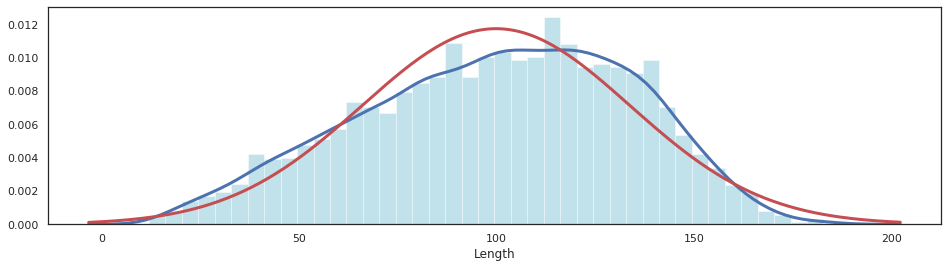

In [63]:
ax = sns.distplot(lengths, kde=True, rug=False, fit=stats.norm, color="c", kde_kws={"color": "b", "lw": 3}, fit_kws={"color": "r", "lw": 3})
ax.set(xlabel='Length');

### Word count distribution

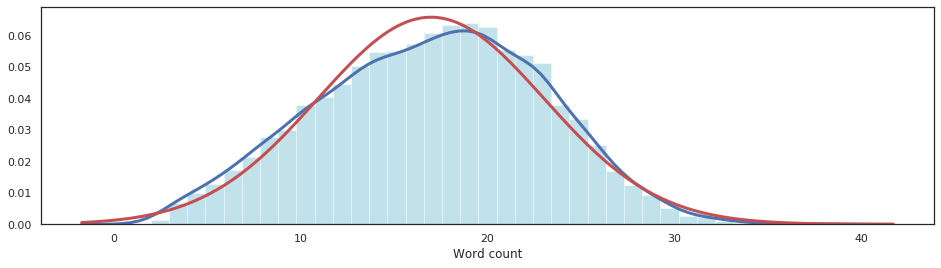

In [64]:
ax = sns.distplot(num_words, bins=max(num_words), kde=True, rug=False, fit=stats.norm, color="c", kde_kws={"color": "b", "lw": 3}, fit_kws={"color": "r", "lw": 3})
ax.set(xlabel='Word count');

### Phonemized length distribution

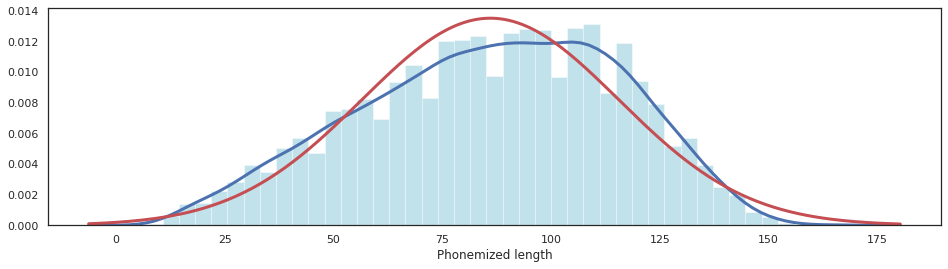

In [29]:
ax = sns.distplot(lengths_phon, kde=True, rug=False, fit=stats.norm, color="c", kde_kws={"color": "b", "lw": 3}, fit_kws={"color": "r", "lw": 3})
ax.set(xlabel='Phonemized length');

### Duration vs Length

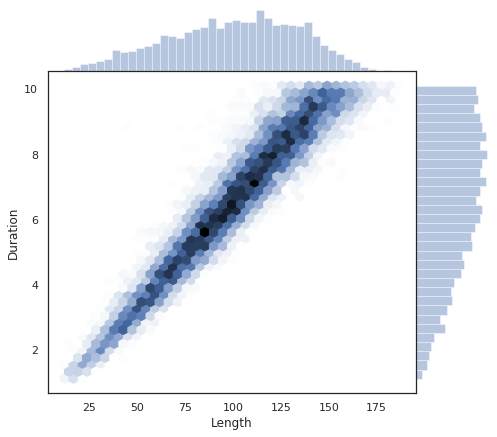

In [65]:
ax = sns.jointplot(lengths, durations, kind="hex", space=0, color="b")
ax.fig.set_figwidth(7)
ax.ax_joint.set(xlabel='Length', ylabel='Duration');

In [53]:
sns.set_style("whitegrid")

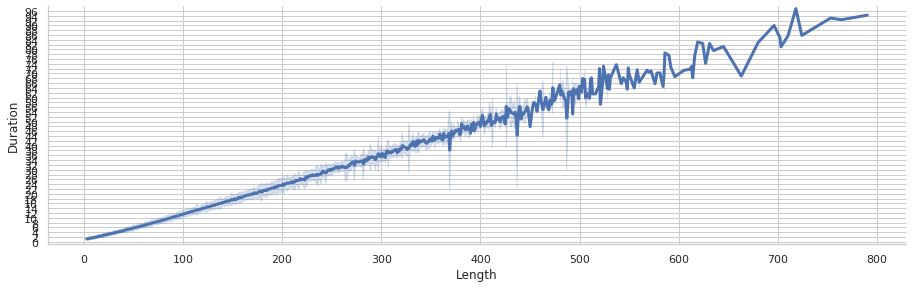

In [54]:
df = pd.DataFrame(list(zip(lengths, durations)), columns=['Length','Duration'])
ax = sns.relplot(x="Length", y="Duration", kind="line", ci="sd", linewidth=3, data=df)
ax.fig.set_figwidth(15)
ax.fig.set_figheight(4)
ax.set(yticks=np.arange(round(min(durations)), max(durations) + 1,2))
plt.ylim(min(durations) - 1, max(durations) + 1);

In [55]:
sns.set_style("white")

### Duration vs Phonemized length

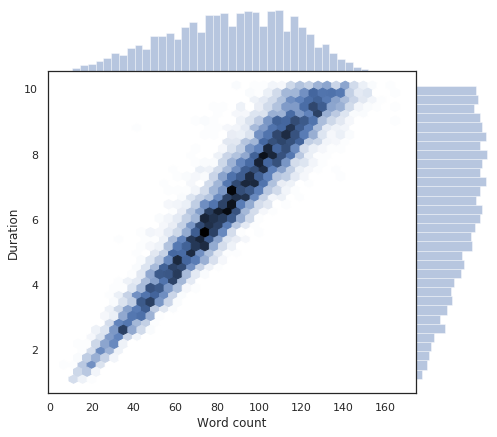

In [34]:
ax = sns.jointplot(lengths_phon, durations, kind="hex", space=0, color="b")
ax.fig.set_figwidth(7)
ax.ax_joint.set(xlabel='Word count', ylabel='Duration');

In [35]:
sns.set_style("whitegrid")

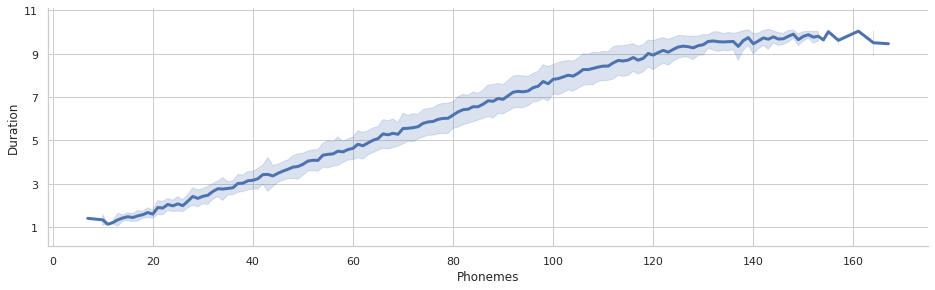

In [36]:
df = pd.DataFrame(list(zip(lengths_phon, durations)), columns=['Phonemes','Duration'])
ax = sns.relplot(x="Phonemes", y="Duration", kind="line", ci="sd", linewidth=3, data=df)
ax.fig.set_figwidth(15)
ax.fig.set_figheight(4)
ax.set(yticks=np.arange(round(min(durations)), max(durations) + 1, 2))
plt.ylim(min(durations) - 1, max(durations) + 1);

In [37]:
sns.set_style("white")

### Phonemes distribution

In [38]:
symbols_phon = hp.phonemes.replace(' ', '')
symbols_phon

'pbtdkɡfvθðszʃʒhmnŋn̩ll̩rjwʔɪeœɒʌʊiːᵻaɔuəɑɜˌˈ'

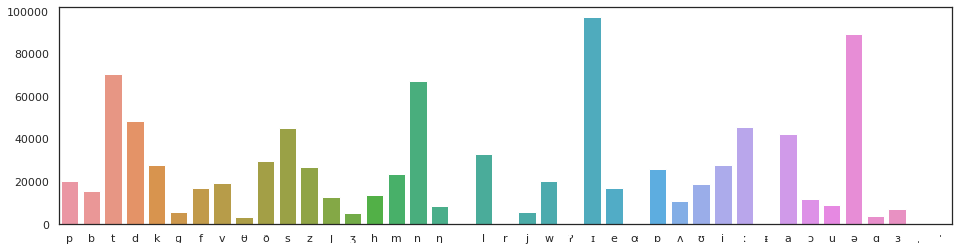

In [39]:
sns.barplot(x=list(symbols_phon), y=[freq_phon[x] for x in symbols_phon]);